In [7]:
import sys
sys.executable
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from pandas import DataFrame
from pandas import read_csv
import math
from numpy import savetxt
from keras import layers
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.models import Model, Sequential
from scipy.integrate import odeint, RK45
from tensorflow.keras.utils import plot_model
import timeit
tf.keras.backend.set_floatx('float64')

tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, v1, x2, v2, x3, v3 = w
    m, k, kp, d, u1, u2, dist = p

    # Create f = (x1',y1',x2',y2'):
    f = [v1,
         (k * ((-2 * x1) + x2) + kp * (-x1 ** 3 + (x2 - x1) ** 3) + d * (v2-2*v1)) / m + u1,
         v2,
         (k * (x1 - (2 * x2) + x3) + kp * ((x3 - x2) ** 3 - (x2 - x1) ** 3) + d * (v1-2*v2+v3)) / m + u2,
         v3,
         (k * (x2 - x3) + kp * ((x2 - x3) ** 3) + d* (v2-v3)) / m + dist]
    return f

In [19]:
num_rollouts= 1
# Masses:
m = 0.5 
# Spring constants
kp = 63.5
k = 217.0
#damping constant
d= 0.25
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

num_data= 20003
interval= 0.001
stoptime = interval*(num_data)
np.random.seed(56)
hist= np.zeros((1,15))

for roll in range(1):
    act1= 3000*(np.random.rand(num_data)-0.5)
    act2= 3000*(np.random.rand(num_data)-0.5)
    dist = 1000*(np.random.rand(num_data)-0.5)
    #Initial states
    w0= np.zeros((1,6))
    #w0 = np.random.randn(1,6) 
    w0= w0.flatten()
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, d, act1[0], act2[0], dist[0]]
    # Call the ODE solver.
    t1= np.array([0,interval])
    wsol1 = odeint(vectorfield, w0, t1, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    prevv= prev
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, d, act1[1], dist[1], act2[1]]
    # Call the ODE solver.
    t2= np.array([0+interval,interval+interval])
    wsol1 = odeint(vectorfield, w0, t2, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    curr = np.hstack((prevv, prev, np.array([[act1[1]]]),np.array([[dist[1]]]),np.array([[act2[1]]]),wcurr))
    hist= np.vstack((hist, curr))
   
    lag=2
    for ts in range(num_data-lag):
        prevv = prev
        t = np.array([stoptime * float(ts+lag) / (num_data), stoptime * float(ts + lag + 1) / (num_data)])
        p = [m, k, kp, d, act1[ts+lag],  dist[ts+lag], act2[ts+lag]]
        # Call the ODE solver.
        wsol1 = odeint(vectorfield, w0, t, args=(p,),
            atol=abserr, rtol=relerr)
        wsol1 = wsol1.flatten()
        w0 = wsol1[6:]
        prev = np.array([[wsol1[0],wsol1[2],wsol1[4]]])
        action= [act1[ts+lag],act2[ts+lag]]
        new = np.hstack((prevv,prev,np.array([[act1[ts+lag]]]),np.array([[dist[ts+lag]]]),np.array([[act2[ts+lag]]]),np.array([w0])))
        hist = np.vstack((hist, new))

hist=pd.DataFrame(data=hist,columns =["prev11", "prev22","prev33","prev1","prev2","prev3","u1","dist.","u2","x1", "v1", "x2", "v2", "x3", "v3"])
df=hist[1:][{"u1","dist.","u2","prev11","prev22","prev33","prev1","prev2","prev3","x1", "v1", "x2", "v2", "x3", "v3"}]
#df=hist[1:][{"u1","u2","dist.","x1", "x3"}]
#df=hist[1:]
#df = df[['u1','u2','x1','x3']]
df = df[['u1','dist.','u2',"prev11","prev22","prev33","prev1","prev2","prev3",'x1','v1','x2','v2','x3','v3']]
df

,u1,dist.,u2,prev11,prev22,prev33,prev1,prev2,prev3,x1,v1,x2,v2,x3,v3
1,-499.763202,306.627574,-486.600032,0.000000,0.000000,0.000000,0.000726,0.000422,-0.000235,0.001927,0.950647,0.001420,1.150173,-0.000948,-0.954980
2,521.104874,-403.494362,-1348.827208,0.000726,0.000422,-0.000235,0.001927,0.001420,-0.000948,0.003138,1.469691,0.002367,0.744214,-0.002576,-2.300968
3,-910.828748,12.187362,953.607999,0.001927,0.001420,-0.000948,0.003138,0.002367,-0.002576,0.004151,0.556184,0.003116,0.752936,-0.004398,-1.343337
4,-436.660606,234.664686,-694.906822,0.003138,0.002367,-0.002576,0.004151,0.003116,-0.004398,0.004487,0.117373,0.003984,0.982632,-0.006086,-2.033183
5,940.097860,216.084749,1434.544282,0.004151,0.003116,-0.004398,0.004487,0.003984,-0.006086,0.005074,1.055304,0.005071,1.192413,-0.007399,-0.592502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19998,200.720252,-351.554062,114.049756,-0.581707,-0.893371,-0.818234,-0.568132,-0.896018,-0.809832,-0.554659,13.622013,-0.898594,-2.648985,-0.801057,8.808092
19999,1001.507979,-143.393777,-872.690193,-0.568132,-0.896018,-0.809832,-0.554659,-0.898594,-0.801057,-0.540493,14.708161,-0.901207,-2.575196,-0.792710,7.885041
20000,-1171.240736,17.013966,1056.098074,-0.554659,-0.898594,-0.801057,-0.540493,-0.901207,-0.792710,-0.526335,13.605684,-0.903660,-2.328264,-0.784324,8.886116
20001,164.703120,479.561948,1345.676161,-0.540493,-0.901207,-0.792710,-0.526335,-0.903660,-0.784324,-0.512619,13.824517,-0.905628,-1.606152,-0.774795,10.171523


In [20]:
NN_in= df[{"u1","u2","dist."}]
NN_in= NN_in[['u1','dist.','u2']].shift(-1)
NN_label= df[{"x1", "x3"}]
NN_label= NN_label[ ["x1", "x3"] ]
NN_previous= df[{"prev11","prev33","prev1","prev3"}]
NN_previous= NN_previous[ ["prev11","prev33"] ]
diff1= df["x1"] - df["prev1"]
diff3= df["x3"] - df["prev3"]
diff21= df["x1"] - df["prev11"]
diff23= df["x3"] - df["prev33"]
df.insert(7, "diff21", diff21)
df.insert(8, "diff23", diff23)
df.insert(9, "diff1", diff1)
df.insert(10, "diff3", diff3)
bothdiff= df[["diff1","diff3"]].shift(0)
bothdiff2= df[["diff21","diff23"]].shift(0)
frames = [NN_in,bothdiff2, NN_label, NN_previous, bothdiff]
df = pd.concat(frames, axis=1)
af=df.dropna()

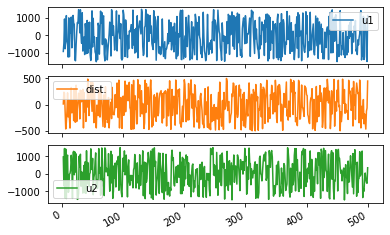

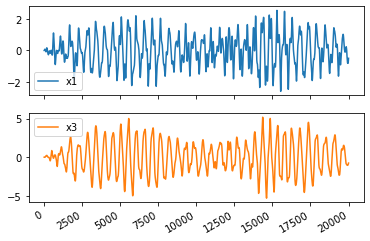

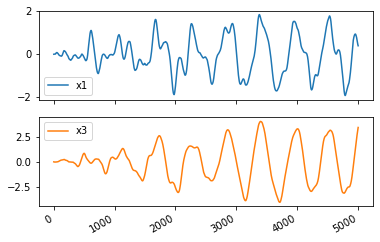

In [21]:
#max(df[{'diff1'}].values)
plot_cols = ['u1','dist.','u2']
plot_features = df[plot_cols][1:500]
_ = plot_features.plot(subplots=True)
plot_states = ['x1', 'v1', 'x2', 'v2', 'x3', 'v3']
plot_states = ['x1', 'x3']
plot_features = df[plot_states][:]
_ = plot_features.plot(subplots=True)
plot_out= ['x1','x3']
plot_features = df[plot_out][1:5000]
_ = plot_features.plot(subplots=True)

In [22]:
df.std()

u1        868.666971
dist.     287.600499
u2        870.359939
diff21      0.038767
diff23      0.055462
x1          0.985177
x3          2.099099
prev11      0.985164
prev33      2.099084
diff1       0.019389
diff3       0.027734
dtype: float64

In [23]:
df= af[ ["u1","dist.","u2","x1", "x3","diff21","diff23","diff1","diff3"] ][:]
#df= af[ ["u1","dist.","u2","x1", "x3","diff1","diff3"] ]

df.to_csv('u1500dampvalidationdatanewage20k_0.001ssim.csv',index=False)
df

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
1,521.104874,-403.494362,-1348.827208,0.001927,-0.000948,0.001927,-0.000948,0.001201,-0.000713
2,-910.828748,12.187362,953.607999,0.003138,-0.002576,0.002412,-0.002341,0.001210,-0.001628
3,-436.660606,234.664686,-694.906822,0.004151,-0.004398,0.002223,-0.003450,0.001013,-0.001822
4,940.097860,216.084749,1434.544282,0.004487,-0.006086,0.001350,-0.003511,0.000337,-0.001688
5,-756.451339,-131.011105,-1394.879638,0.005074,-0.007399,0.000923,-0.003001,0.000586,-0.001313
...,...,...,...,...,...,...,...,...,...
19997,200.720252,-351.554062,114.049756,-0.568132,-0.809832,0.027518,0.016393,0.013575,0.008403
19998,1001.507979,-143.393777,-872.690193,-0.554659,-0.801057,0.027048,0.017177,0.013473,0.008774
19999,-1171.240736,17.013966,1056.098074,-0.540493,-0.792710,0.027639,0.017121,0.014166,0.008347
20000,164.703120,479.561948,1345.676161,-0.526335,-0.784324,0.028324,0.016733,0.014158,0.008386


In [40]:
aaa= pd.read_csv('u1500newage20000_0.001ssim.csv')
aaa

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
0,308.290128,399.234052,668.173469,0.000542,0.000483,0.000542,0.000483,0.000469,0.000544
1,134.649549,-327.561206,1254.959857,0.001487,0.002027,0.001414,0.002088,0.000945,0.001544
2,-229.035602,86.060633,969.802616,0.002652,0.004531,0.002110,0.004049,0.001165,0.002504
3,437.682339,-470.680398,440.690106,0.003767,0.008146,0.002280,0.006119,0.001115,0.003614
4,-187.238366,-278.836089,-1296.182940,0.004983,0.012461,0.002330,0.007929,0.001215,0.004315
...,...,...,...,...,...,...,...,...,...
19996,-419.620158,83.200125,-866.021990,2.963997,0.921033,0.049988,0.055637,0.022757,0.030118
19997,377.659938,452.330307,-69.285694,2.982265,0.954572,0.041025,0.063658,0.018268,0.033539
19998,-323.481116,-219.211301,-1253.296930,2.996222,0.991530,0.032225,0.070497,0.013957,0.036957
19999,-1376.530242,295.345317,-787.021904,3.005842,1.031527,0.023576,0.076955,0.009619,0.039998


<Figure size 576x216 with 0 Axes>

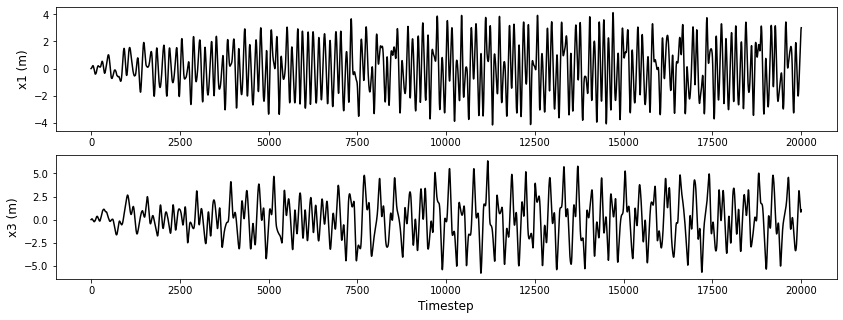

In [41]:
plt.figure(figsize=(8,3))
fig, axs = plt.subplots(2,figsize=(14,5))
x= range(20001)
y=aaa.iloc[:,3].values
z=aaa.iloc[:,4].values
#fig.suptitle('Undamped System Trajectory with Maximum Actuation Force of 1500 N')
axs[0].plot(x, y, 'k')
axs[1].plot(x, z, 'k')
axs[0].set_ylabel("x1 (m)",fontsize=12) 
axs[1].set_ylabel("x3 (m)", fontsize=12) 
axs[1].set_xlabel("Timestep",fontsize=12) 
#axs[0].set_title("Position (m)") 
#axs[0].plot(range(5000), aaa.iloc[:,3].values, 'B')
plt.savefig('u1500uncontrolledpositionx1.png', dpi=300)

In [42]:
aaa= pd.read_csv('u1500dampvalidationdatanewage20k_0.001ssim.csv')

<Figure size 576x216 with 0 Axes>

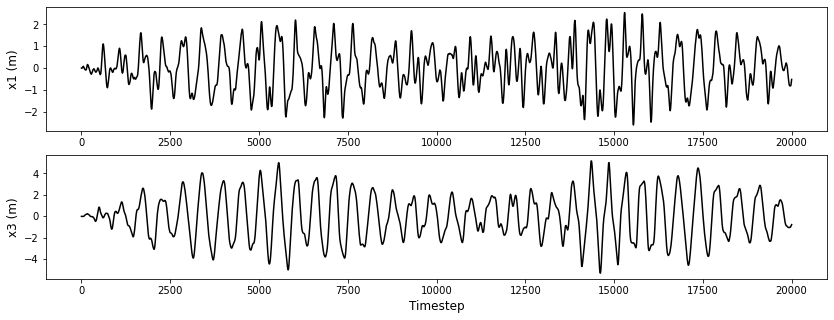

In [43]:
plt.figure(figsize=(8,3))
fig, axs = plt.subplots(2, figsize=(14,5))
x= range(20001)
y=aaa.iloc[:,3].values
z=aaa.iloc[:,4].values
#fig.suptitle('Damped System Trajectory with Maximum Actuation Force of 1500 N')
axs[0].plot(x, y,'k')
axs[1].plot(x, z,'k')
axs[0].set_ylabel("x1 (m)",fontsize=12) 
axs[1].set_ylabel("x3 (m)", fontsize=12) 
axs[1].set_xlabel("Timestep",fontsize=12) 
#axs[0].set_title("Position (m)") 
#axs[0].plot(range(5000), aaa.iloc[:,3].values, 'B')
plt.savefig('u1500dampeduncontrolledpositionx1.png', dpi=300)

In [44]:
aaa= pd.read_csv('dist100changerefreinf_startsim40000_train500-250_batch16sim300-1000-1000-pen10xcost.csv')

<Figure size 576x216 with 0 Axes>

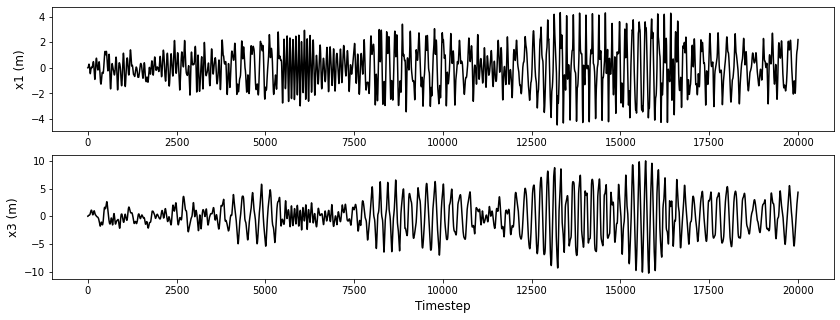

In [45]:
plt.figure(figsize=(8,3))
fig, axs = plt.subplots(2, figsize=(14,5))
x= range(20001)
y=aaa.iloc[:20001,3].values
z=aaa.iloc[:20001,4].values
#fig.suptitle('Damped System Trajectory with Maximum Actuation Force of 1500 N')
axs[0].plot(x, y,'k')
axs[1].plot(x, z,'k')
axs[0].set_ylabel("x1 (m)",fontsize=12) 
axs[1].set_ylabel("x3 (m)", fontsize=12) 
axs[1].set_xlabel("Timestep",fontsize=12) 
#axs[0].set_title("Position (m)") 
#axs[0].plot(range(5000), aaa.iloc[:,3].values, 'B')
plt.savefig('uctrdamp500-500.png', dpi=300)